In [28]:
%pip install pandas scikit-learn numpy matplotlib seaborn 

In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.sparse import hstack
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
df = pd.read_csv('amazon_products.csv', encoding='ISO-8859-1', on_bad_lines='skip')

print(df.head(5))

                                               title     price rating  \
0  Hatch Restore 3 Sunrise Alarm Clock, Sound Mac...  $169.99     4.3   
1  Amazon Basics Small Digital Oval Alarm Clock W...    $9.87     4.4   
2  Hatch Restore 3 Sunrise Alarm Clock, Sound Mac...  $169.99     4.3   
3  Amazon Basics Small Digital Oval Alarm Clock W...    $9.87     4.4   
4  Alarm Clock,Table Lamp with Wireless Charging,...   $41.99     4.2   

  sold_quantity Unnamed: 4  
0          20K+        NaN  
1          10K+        NaN  
2          20K+        NaN  
3          10K+        NaN  
4           NaN        NaN  


In [114]:
df.shape

(11186, 5)

In [115]:
df.dtypes

title            object
price            object
rating           object
sold_quantity    object
Unnamed: 4       object
dtype: object

In [131]:
df.isna().sum()

title               0
price               0
rating              0
sold_quantity       0
Unnamed: 4       7636
dtype: int64

In [132]:
print(df.head(5))

                                               title     price rating  \
0  Hatch Restore 3 Sunrise Alarm Clock, Sound Mac...  $169.99     4.3   
1  Amazon Basics Small Digital Oval Alarm Clock W...    $9.87     4.4   
2  Hatch Restore 3 Sunrise Alarm Clock, Sound Mac...  $169.99     4.3   
3  Amazon Basics Small Digital Oval Alarm Clock W...    $9.87     4.4   
5  Netzu Wooden Alarm Clock, Loud Digital Plug-in...   $15.99     4.4   

  sold_quantity Unnamed: 4  
0          20K+        NaN  
1          10K+        NaN  
2          20K+        NaN  
3          10K+        NaN  
5          400+        NaN  


In [165]:
import re

def parse_price(value):
    if isinstance(value, str):
        # value = value.replace('$', '').replace(',', '').replace('+', '').strip()
        if re.search(r'[a-zA-Z]', value): 
            return None
        if 'K' in value.upper():
            return float(value.upper().replace('K', '')) * 1000
        elif 'M' in value.upper():
            return float(value.upper().replace('M', '')) * 1_000_000
        try:
            return float(value)
        except ValueError:
            return None
    return value  # If already numeric

In [166]:
df['sold_quantity'] = df['sold_quantity'].apply(parse_price)
df['sold_quantity'] = pd.to_numeric(df['sold_quantity'], errors='coerce')
print(df['sold_quantity'].head(10))

5     400.0
6     100.0
10    600.0
12    100.0
21    400.0
28    200.0
29    100.0
31    100.0
32    600.0
37     50.0
Name: sold_quantity, dtype: float64


In [167]:
print(df.head(5))

                                                title  price rating  \
5   Netzu Wooden Alarm Clock, Loud Digital Plug-in...  15.99    4.4   
6   Sound Machine Alarm Clock for Bedroom: Dimmabl...  22.79    4.5   
10  Alarm Clock Speaker Wireless Charger, Digital ...  49.99    4.4   
12  Geevon Small Travel Alarm Clock, Digital Alarm...  15.99    4.3   
21  Netzu Wooden Alarm Clock, Loud Digital Plug-in...  15.99    4.4   

    sold_quantity Unnamed: 4  
5           400.0        NaN  
6           100.0        NaN  
10          600.0        NaN  
12          100.0        NaN  
21          400.0        NaN  


In [168]:
df['title'] = df['title'].fillna('Unknown').astype(str).str.strip()

# Drop rows with missing price or rating
df = df.dropna(subset=['price', 'rating'])

In [172]:
df = df.dropna(subset=['price', 'rating','sold_quantity'])

In [173]:
print(df.head(5))

                                                title  price rating  \
5   Netzu Wooden Alarm Clock, Loud Digital Plug-in...  15.99    4.4   
6   Sound Machine Alarm Clock for Bedroom: Dimmabl...  22.79    4.5   
10  Alarm Clock Speaker Wireless Charger, Digital ...  49.99    4.4   
12  Geevon Small Travel Alarm Clock, Digital Alarm...  15.99    4.3   
21  Netzu Wooden Alarm Clock, Loud Digital Plug-in...  15.99    4.4   

    sold_quantity Unnamed: 4  
5           400.0        NaN  
6           100.0        NaN  
10          600.0        NaN  
12          100.0        NaN  
21          400.0        NaN  


In [174]:
vectorizer = TfidfVectorizer(max_features=100, min_df=2)
title_tfidf = vectorizer.fit_transform(df['title'])

In [175]:
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[['rating', 'sold_quantity']])

# Combine features
X = hstack([title_tfidf, numeric_scaled])
y = df['price']

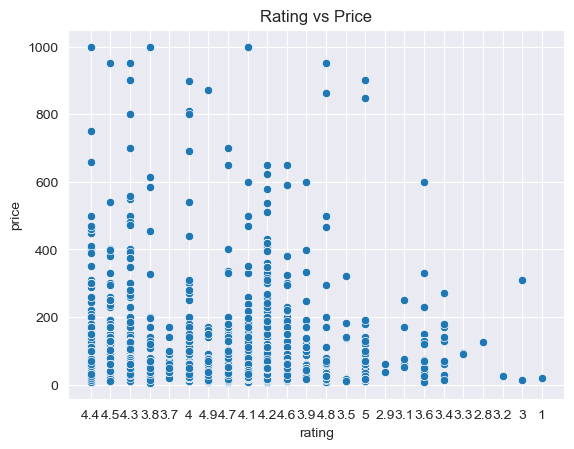

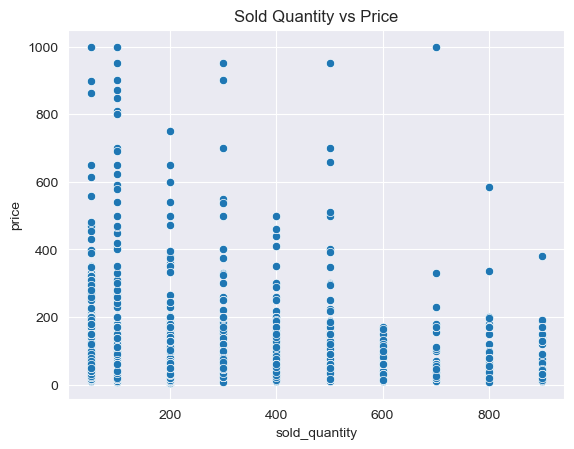

In [176]:
sns.scatterplot(data=df, x='rating', y='price')
plt.title("Rating vs Price")
plt.show()

sns.scatterplot(data=df, x='sold_quantity', y='price')
plt.title("Sold Quantity vs Price")
plt.show()

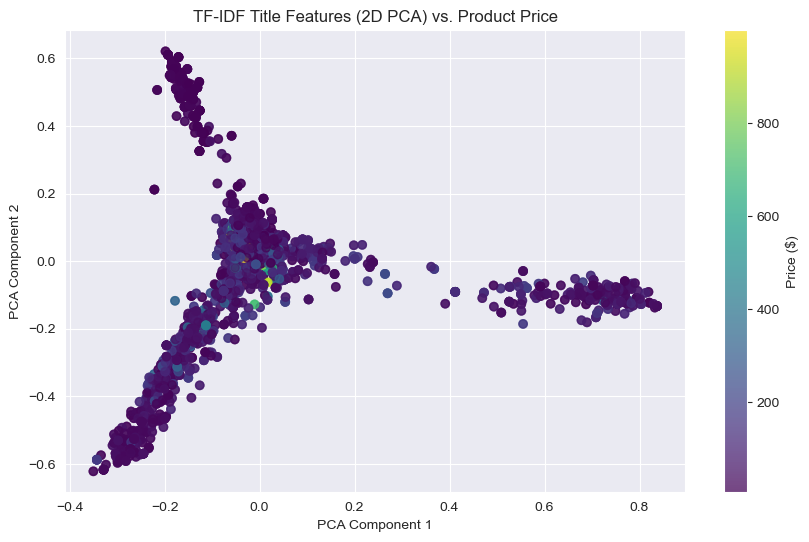

In [177]:
# Reduce TF-IDF title features to 2D for plotting
pca = PCA(n_components=2)
title_pca = pca.fit_transform(title_tfidf.toarray())

# Create a DataFrame with PCA components and price
title_price_df = pd.DataFrame({
    'PCA1': title_pca[:, 0],
    'PCA2': title_pca[:, 1],
    'Price': df['price']
})

# Plot PCA components colored by price
plt.figure(figsize=(10, 6))
scatter = plt.scatter(title_price_df['PCA1'], title_price_df['PCA2'],
                      c=title_price_df['Price'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Price ($)')
plt.title('TF-IDF Title Features (2D PCA) vs. Product Price')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [179]:
# Linear Regression Model Training
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [180]:
#Random ForestRegressor Model Training
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [161]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n {name}")
    print("MAE :", round(mean_absolute_error(y_true, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))
    print(f"Model Accuracy: {round(r2_score(y_true, y_pred), 3) * 100:.2f}%")
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest Regressor", y_test, y_pred_rf)


 Linear Regression
MAE : 59.32
RMSE: 97.27
Model Accuracy: 41.70%

 Random Forest Regressor
MAE : 14.78
RMSE: 39.31
Model Accuracy: 90.50%


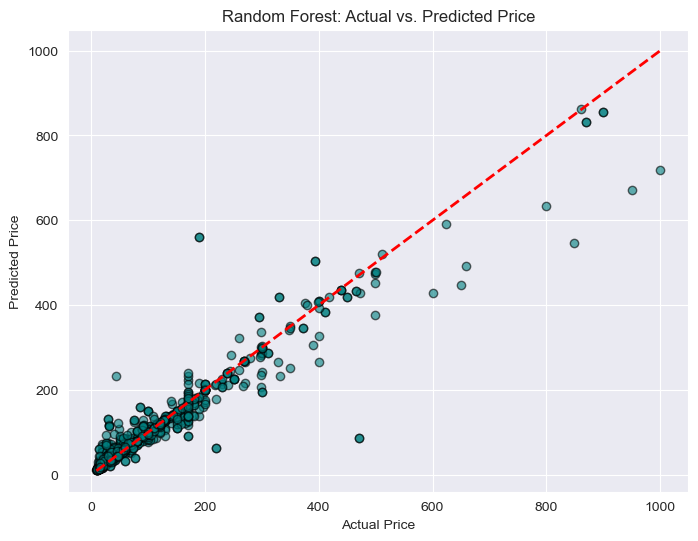

In [162]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='teal', edgecolors='k')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs. Predicted Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect line
plt.grid(True)
plt.show()

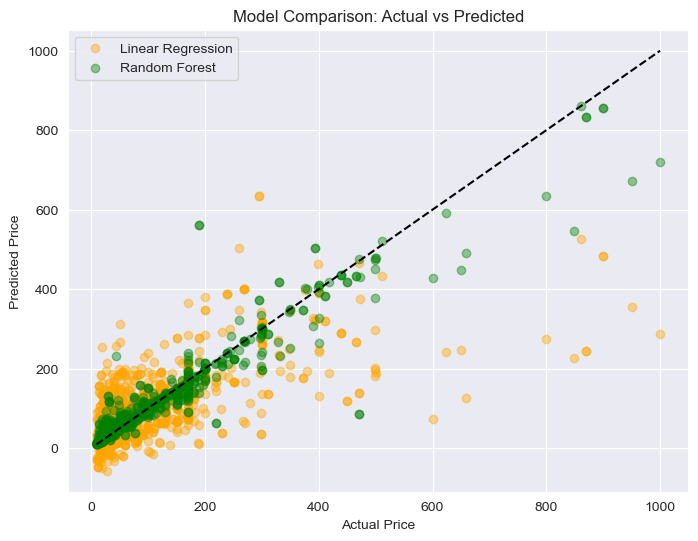

In [163]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.4, label="Linear Regression", color='orange')
plt.scatter(y_test, y_pred_rf, alpha=0.4, label="Random Forest", color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Model Comparison: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

In [181]:
# Predict on New User Input
def estimate_price(title, rating, sold_quantity):
    title_vec = vectorizer.transform([title])

    # Use DataFrame with correct feature names for scaler
    numeric_input_df = pd.DataFrame([[rating, sold_quantity]], columns=['rating', 'sold_quantity'])
    numeric_input_scaled = scaler.transform(numeric_input_df)

    # Combine title + numeric
    features = hstack([title_vec, numeric_input_scaled])
    prediction = rf.predict(features)[0]
    return round(prediction, 2)

# Example Usage
user_input = {
    "title": "20000mAh Solar Charger for Cell Phone IPhone, Portable Solar Power Bank with Dual 5V USB Ports, 2 LED Light Flashlight, Compass Battery Pack for Outdoor Camping Hiking(Orange)",
    "rating": 4.4,
    "sold_quantity": 1000
}

estimated_price = estimate_price(user_input['title'], user_input['rating'], user_input['sold_quantity'])
print(f"\n💰 Estimated Price for \"{user_input['title']}\": ${estimated_price}")


💰 Estimated Price for "20000mAh Solar Charger for Cell Phone IPhone, Portable Solar Power Bank with Dual 5V USB Ports, 2 LED Light Flashlight, Compass Battery Pack for Outdoor Camping Hiking(Orange)": $84.91
